# Dependencies

In [1]:
import os, warnings, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold


SEED = 0
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 160)

In [2]:
# Preprocess data
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()\

# Preprocess inputs
CLS = 0
PAD = 1
SEP = 2

def preprocess_roberta(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][:max_seq_len]
    attention_mask = encoded['attention_mask'][:max_seq_len]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def preprocess_roberta_tail(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][-max_seq_len:]
    attention_mask = encoded['attention_mask'][-max_seq_len:]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def get_data(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    y_data = []
    y_data_int = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])

        y_data.append(getattr(row, 'toxic'))
        y_data_int.append(getattr(row, 'toxic_int'))

    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    y_data = [np.asarray(y_data, dtype=np.float32), 
              np.asarray(y_data_int, dtype=np.int8)]
    
    return x_data, y_data
    
def get_data_valid(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    y_data = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])

        y_data.append(getattr(row, 'toxic'))

    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    y_data = np.asarray(y_data, dtype=np.int8)
    
    return x_data, y_data

def get_data_test(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])


    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    return x_data

# Parameters

In [3]:
MAX_LEN = 128
tokenizer_path = 'jplu/tf-xlm-roberta-large'
sample_rate = 2

# Load data

In [4]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

n_neg_samp_df1 = len(train1.query('toxic > .8')) * sample_rate
n_neg_samp_df2 = len(train2.query('toxic > .8')) * sample_rate

train_df = pd.concat([train1[['comment_text', 'toxic']].query('toxic > .8'),
                      train1[['comment_text', 'toxic']].query('toxic <= .2').sample(n=n_neg_samp_df1, random_state=SEED),
                      train2[['comment_text', 'toxic']].query('toxic > .8'),
                      train2[['comment_text', 'toxic']].query('toxic <= .2').sample(n=n_neg_samp_df2, random_state=SEED)
                    ])
train_df['toxic_int'] = train_df['toxic'].round().astype(int)

print(f'Dataframe 1 samples: toxic|non-toxic | {n_neg_samp_df1 // sample_rate}|{n_neg_samp_df1}')
print(f'Dataframe 2 samples: toxic|non-toxic | {n_neg_samp_df2 // sample_rate}|{n_neg_samp_df2}')
print('Train samples %d' % len(train_df))
display(train_df.head())

Dataframe 1 samples: toxic|non-toxic | 21384|42768
Dataframe 2 samples: toxic|non-toxic | 25124|50248
Train samples 139524


,comment_text,toxic,toxic_int
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1.0,1
12,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any on...",1.0,1
16,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1.0,1
42,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holoc...",1.0,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1.0,1


# Tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, lowercase=False)

## Preprocess

In [6]:
train_df['comment_text'] = train_df.apply(lambda x: clean_text(x['comment_text']), axis=1)
train_df['length'] = train_df['comment_text'].apply(lambda x : len(x))
train_df['word_count'] = train_df['comment_text'].apply(lambda x : len(x.split(' ')))
train_df['token_count'] = train_df['comment_text'].apply(lambda x : len(tokenizer.encode(x)))

print('Train samples %d' % len(train_df))
display(train_df.head())
display(train_df.describe())

Train samples 139524


,comment_text,toxic,toxic_int,length,word_count,token_count
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1.0,1,44,8,19
12,"Hey... what is it.. @ | talk . What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one ...",1.0,1,318,53,95
16,"Bye! Don't look, come or think of comming back! Tosser.",1.0,1,55,10,21
42,"You are gay or antisemmitian? Archangel WHite Tiger Meow! Greetingshhh! Uh, there are two ways, why you do erased my comment about WW, that holocaust was br...",1.0,1,633,114,187
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1.0,1,40,8,18


,toxic,toxic_int,length,word_count,token_count
count,139524.000000,139524.000000,139524.000000,139524.000000,139524.000000
mean,0.324032,0.333333,300.490847,52.667699,77.580158
std,0.439128,0.471406,439.697877,75.998305,120.766991
min,0.000000,0.000000,0.000000,1.000000,2.000000
25%,0.000000,0.000000,76.000000,14.000000,22.000000
50%,0.000000,0.000000,167.000000,30.000000,44.000000
75%,0.860000,1.000000,358.000000,63.000000,90.000000
max,1.000000,1.000000,5000.000000,2321.000000,2783.000000


## Filter

In [7]:
train_df = train_df[train_df['word_count'] <= 250]
train_df = train_df[train_df['token_count'] <= 1000]
train_df = shuffle(train_df, random_state=SEED).reset_index(drop=True)

print('Train samples %d' % len(train_df))
display(train_df.head())
display(train_df.describe())

Train samples 137045


,comment_text,toxic,toxic_int,length,word_count,token_count
0,Post with your own name or come to my house and call me a slime ball; I'd just love to kick the sh*t out of you.,0.95689,1,112,26,35
1,"Idiot is a word to describe a foolish and senseless person, he's both. Therefore he fits the word, regardless if what you consider an attack. Thanks.",1.00000,1,149,26,40
2,"Hill training up and down is excellent for building up quads prior to skiing. Ski mornings first only at first, not the whole day when conditions deteriorat...",0.00000,0,186,33,43
3,":::::... I'm not sure what, exactly, you would have liked me to protest, —",0.00000,0,74,14,26
4,"== == Hi, Please take a look at my talk section - , started by him. It seems that he did not stop making personal attacks. And in his talk page edit summary...",0.00000,0,175,38,49


,toxic,toxic_int,length,word_count,token_count
count,137045.000000,137045.000000,137045.000000,137045.000000,137045.000000
mean,0.325363,0.334832,257.235930,45.288577,65.839571
std,0.439121,0.471933,261.104745,44.994761,62.997531
min,0.000000,0.000000,0.000000,1.000000,2.000000
25%,0.000000,0.000000,75.000000,14.000000,22.000000
50%,0.000000,0.000000,163.000000,29.000000,43.000000
75%,0.860000,1.000000,342.000000,61.000000,86.000000
max,1.000000,1.000000,4973.000000,250.000000,953.000000


# Data generation sanity check

In [8]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 22
    comment_text = train_df['comment_text'].loc[idx]
    
    x_train, y_train = get_data(train_df[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta)
    
    print('label         : "%.4f"' % y_train[0])
    print('label int     : "%d"'   % y_train[1])
    print('comment_text  : "%s"'   % comment_text)
    print('input_ids     : "%s"'   % x_train[0][0])
    print('attention_mask: "%s"'   % x_train[1][0])
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len
    
    print('-------------------- TAIL --------------------')
    x_train, _ = get_data(train_df[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta_tail)
    
    print('input_ids     : "%s"' % x_train[0][0])
    print('attention_mask: "%s"' % x_train[1][0])
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len


Row 0
label         : "0.9569"
label int     : "1"
comment_text  : "Post with your own name or come to my house and call me a slime ball; I'd just love to kick the sh*t out of you."
input_ids     : "[    0  2795   678   935 10002  9351   707  1380    47   759 18276   136
 11782   163    10 34264    13 16446    74    87    25     2]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]"
-------------------- TAIL --------------------
input_ids     : "[     0     10  34264     13  16446     74     87     25     71   1660
   5161     47 101630     70   7547   1639     18   1810    111    398
      5      2]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]"

Row 1
label         : "1.0000"
label int     : "1"
comment_text  : "Idiot is a word to describe a foolish and senseless person, he's both. Therefore he fits the word, regardless if what you consider an attack. Thanks."
input_ids     : "[     0     87   5670     18     83     10   2565     47  98363     10
 1508

# 5-Fold split

In [9]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['toxic_int'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 109636, Validation size 27409
Fold: 2, Train size: 109636, Validation size 27409
Fold: 3, Train size: 109636, Validation size 27409
Fold: 4, Train size: 109636, Validation size 27409
Fold: 5, Train size: 109636, Validation size 27409


# Label distribution

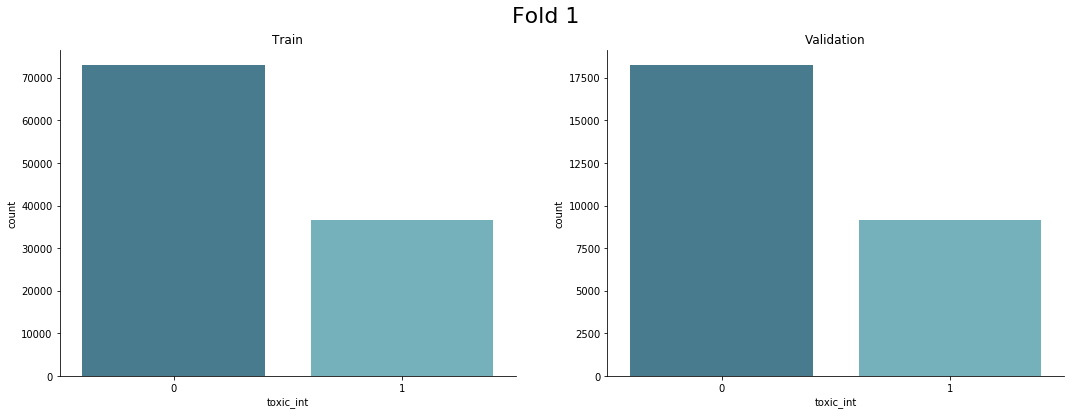

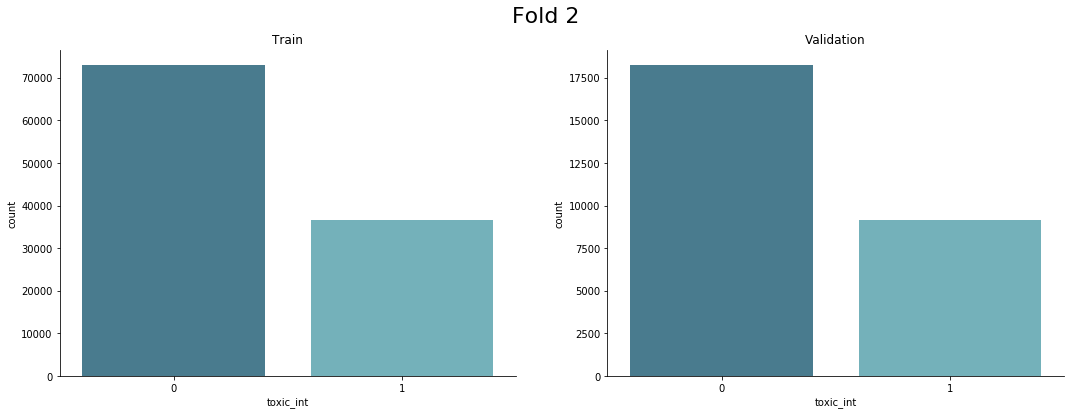

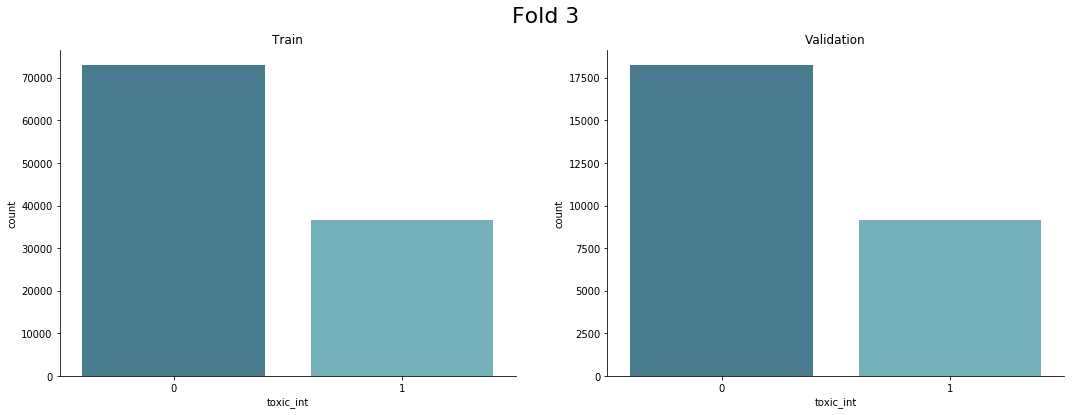

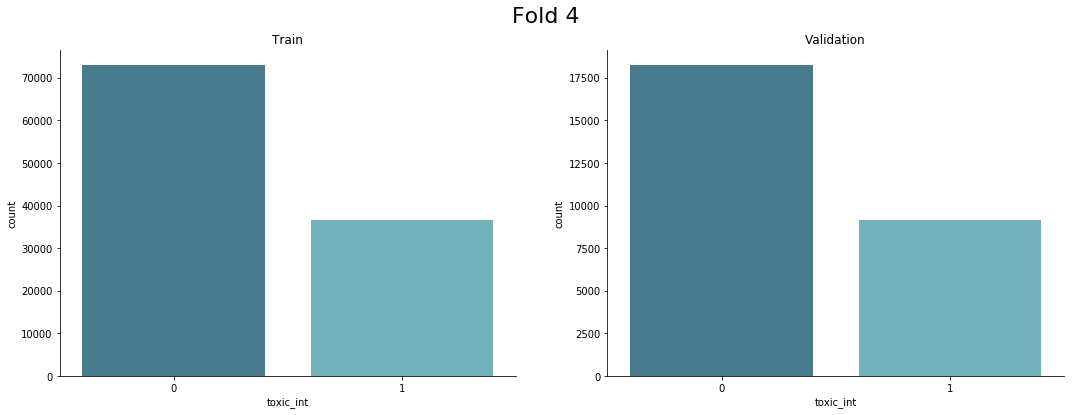

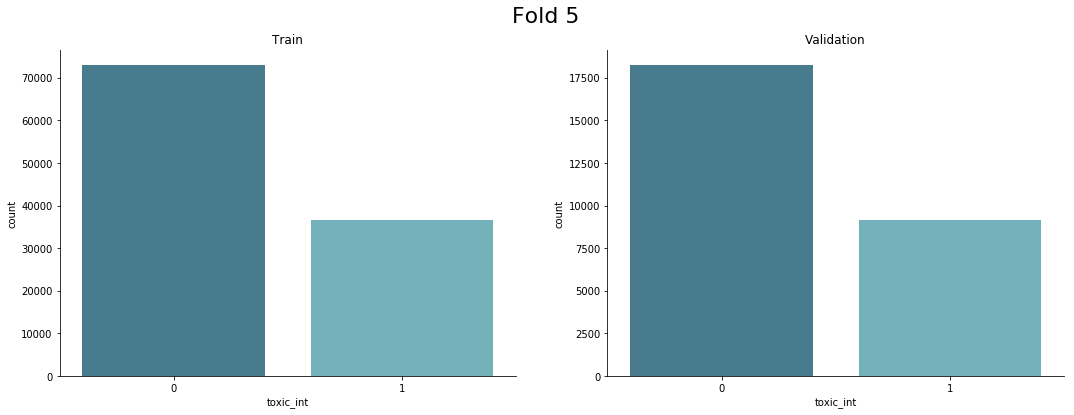

In [10]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="toxic_int", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="toxic_int", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

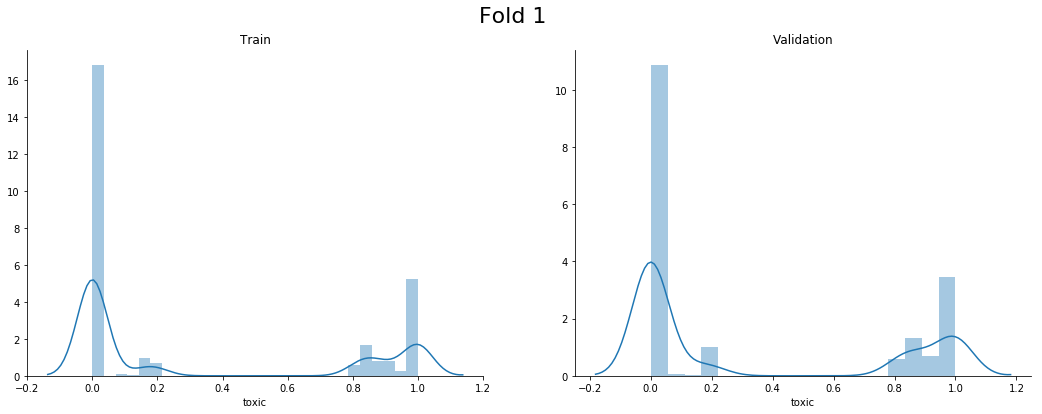

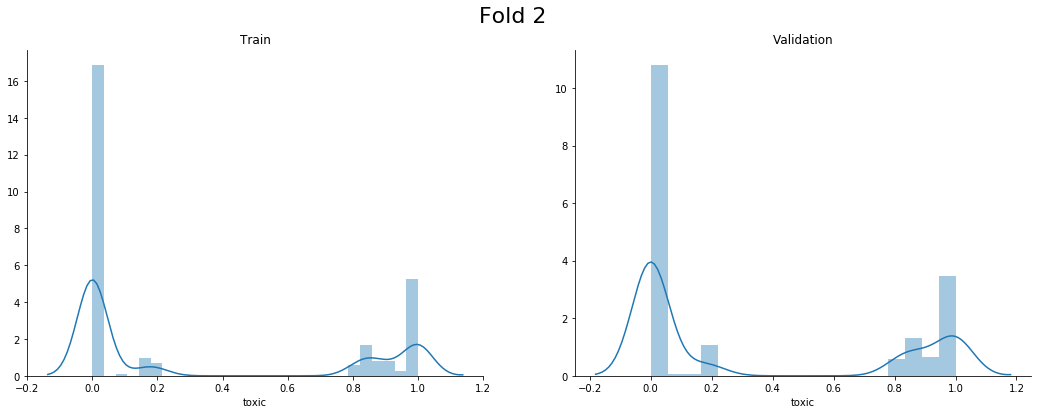

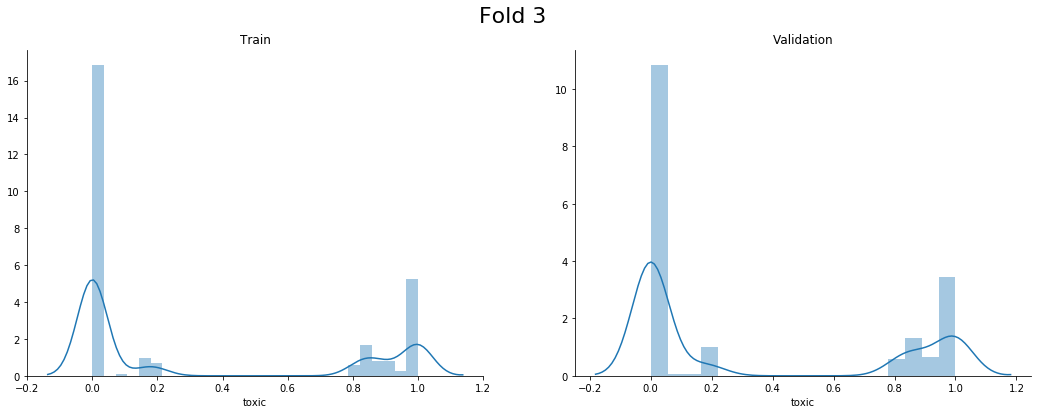

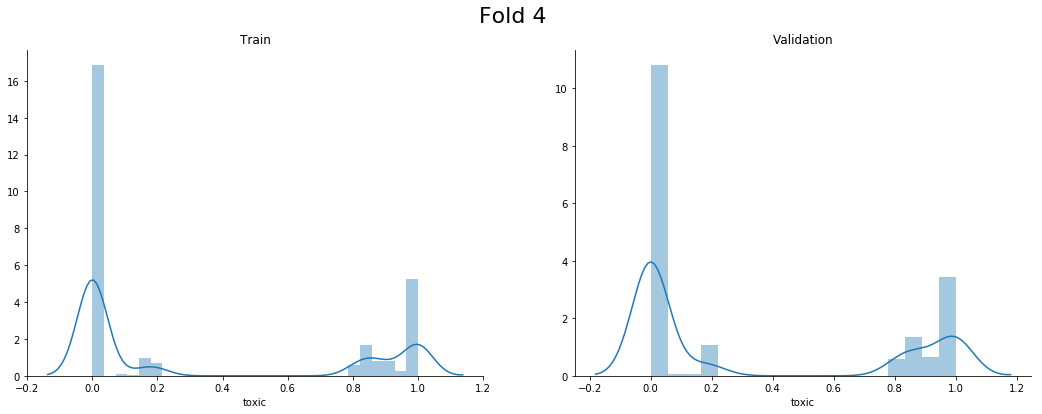

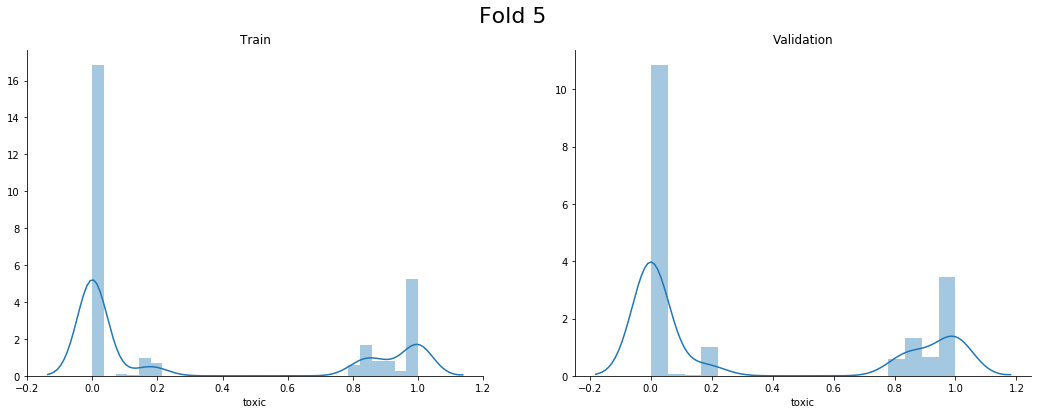

In [11]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['toxic'], ax=ax1).set_title('Train')
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['toxic'], ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

# Output 5-fold set

In [12]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    if fold_n < 1:
        fold_n += 1
        base_path = 'fold_%d/' % fold_n

        # Create dir
        os.makedirs(base_path)

        x_train, y_train = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
        x_valid, y_valid = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
        y_train_float, y_train_int = y_train
        y_valid_float, y_valid_int = y_valid
        x_train, y_train_float, y_train_int =  np.asarray(x_train), np.asarray(y_train_float), np.asarray(y_train_int)
        x_valid, y_valid_float, y_valid_int =  np.asarray(x_valid), np.asarray(y_valid_float), np.asarray(y_valid_int)
        
        np.save(base_path + 'x_train', x_train)
        np.save(base_path + 'y_train', y_train_float)
        np.save(base_path + 'y_train_int', y_train_int)
        np.save(base_path + 'x_valid', x_valid)
        np.save(base_path + 'y_valid', y_valid_float)
        np.save(base_path + 'y_valid_int', y_valid_int)

        print('\nFOLD: %d' % (fold_n))
        print('x_train shape:', x_train.shape)
        print('y_train_float shape:', y_train_float.shape)
        print('y_train_int shape:', y_train_int.shape)
        print('x_valid shape:', x_valid.shape)
        print('y_valid_float shape:', y_valid_float.shape)
        print('y_valid_int shape:', y_valid_int.shape)
        
        #################### ENCODE TAIL ONLY ####################

        x_train, _ = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], 'comment_text', 
                              tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
        x_valid, _ = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], 'comment_text', 
                              tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
        x_train = np.asarray(x_train)
        x_valid = np.asarray(x_valid)
        
        np.save(base_path + 'x_train_tail', x_train)
        np.save(base_path + 'x_valid_tail', x_valid)

        print('\nFOLD: %d [TAIL]' % (fold_n))
        print('x_train shape:', x_train.shape)
        print('x_valid shape:', x_valid.shape)

#  Compress logs dir
!tar -cvzf fold_1.tar.gz fold_1
# !tar -cvzf fold_2.tar.gz fold_2
# !tar -cvzf fold_3.tar.gz fold_3
# !tar -cvzf fold_4.tar.gz fold_4
# !tar -cvzf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
# shutil.rmtree('fold_2')
# shutil.rmtree('fold_3')
# shutil.rmtree('fold_4')
# shutil.rmtree('fold_5')

,comment_text,toxic,toxic_int,length,word_count,token_count,fold_1,fold_2,fold_3,fold_4,fold_5
0,Post with your own name or come to my house and call me a slime ball; I'd just love to kick the sh*t out of you.,0.95689,1,112,26,35,validation,train,train,train,train
1,"Idiot is a word to describe a foolish and senseless person, he's both. Therefore he fits the word, regardless if what you consider an attack. Thanks.",1.00000,1,149,26,40,train,train,train,train,validation
2,"Hill training up and down is excellent for building up quads prior to skiing. Ski mornings first only at first, not the whole day when conditions deteriorat...",0.00000,0,186,33,43,validation,train,train,train,train
3,":::::... I'm not sure what, exactly, you would have liked me to protest, —",0.00000,0,74,14,26,train,train,train,validation,train
4,"== == Hi, Please take a look at my talk section - , started by him. It seems that he did not stop making personal attacks. And in his talk page edit summary...",0.00000,0,175,38,49,train,validation,train,train,train



FOLD: 1
x_train shape: (2, 109636, 128)
y_train_float shape: (109636,)
y_train_int shape: (109636,)
x_valid shape: (2, 27409, 128)
y_valid_float shape: (27409,)
y_valid_int shape: (27409,)

FOLD: 1 [TAIL]
x_train shape: (2, 109636, 128)
x_valid shape: (2, 27409, 128)
fold_1/
fold_1/y_train.npy
fold_1/y_train_int.npy
fold_1/x_train_tail.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy
fold_1/x_valid_tail.npy
fold_1/y_valid_int.npy


# Validation set

In [13]:
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])
# Preprocess
valid_df['comment_text'] = valid_df.apply(lambda x: clean_text(x['comment_text']), axis=1)
valid_df['length'] = valid_df['comment_text'].apply(lambda x : len(x))
valid_df['word_count'] = valid_df['comment_text'].apply(lambda x : len(x.split(' ')))
valid_df['token_count'] = valid_df['comment_text'].apply(lambda x : len(tokenizer.encode(x)))
display(valid_df.head())
display(valid_df.describe())

x_valid, y_valid = get_data_valid(valid_df, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
x_valid, y_valid = np.asarray(x_valid), np.asarray(y_valid)

np.save('x_valid', x_valid)
np.save('y_valid', y_valid)
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)

#################### ENCODE TAIL ONLY ####################

x_valid, _ = get_data_valid(valid_df, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
x_valid =  np.asarray(x_valid)

np.save('x_valid_tail', np.asarray(x_valid))
print('[TAIL] x_valid shape:', x_valid.shape)

,comment_text,lang,toxic,length,word_count,token_count
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo media...,es,0,223,39,61
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, nel fare cio .",it,0,130,21,34
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder años a nivel particular. Las volveria a pasar putas.Fe...",es,1,162,26,43
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siyaset bilimi ana başlığından sonra siyasal ...,tr,0,391,49,94
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecekte(- yıl) bu tip şeyler düşünüyorum. Tab...,tr,0,412,54,102


,toxic,length,word_count,token_count
count,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.153750,359.099000,54.796500,92.410250
std,0.360731,265.423962,38.903098,65.118025
min,0.000000,0.000000,1.000000,2.000000
25%,0.000000,169.000000,27.000000,46.000000
50%,0.000000,269.500000,42.000000,71.000000
75%,0.000000,458.000000,69.250000,116.000000
max,1.000000,1623.000000,204.000000,860.000000


x_valid shape: (2, 8000, 128)
y_valid shape: (8000,)
[TAIL] x_valid shape: (2, 8000, 128)


# Test set

In [14]:
test_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv", usecols=['content'])
# Preprocess
test_df['content'] = test_df.apply(lambda x: clean_text(x['content']), axis=1)
test_df['length'] = test_df['content'].apply(lambda x : len(x))
test_df['word_count'] = test_df['content'].apply(lambda x : len(x.split(' ')))
test_df['token_count'] = test_df['content'].apply(lambda x : len(tokenizer.encode(x)))
display(test_df.head())
display(test_df.describe())

x_test = get_data_test(test_df, 'content', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
x_test = np.asarray(x_test)

np.save('x_test', x_test)
print('x_test shape:', x_test.shape)

#################### ENCODE TAIL ONLY ####################

x_test = get_data_test(test_df, 'content', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
x_test = np.asarray(x_test)

np.save('x_test_tail', x_test)
print('[TAIL] x_test shape:', x_test.shape)

,content,length,word_count,token_count
0,Doctor Who adlı viki başlığına . doctor olarak bir viki yazarı kendi adını eklemiştir. Şahsen düzelttim. Onaylarsanız sevinirim. Occipital,138,19,40
1,"Вполне возможно, но я пока не вижу необходимости выделять материал в отдельную статью. Если про правосудие в СССР будет написано хотя бы килобайт - — тогда ...",459,74,114
2,"Quindi tu sei uno di quelli conservativi , che preferiscono non cancellare. Ok. Avresti lasciato anche sfaccimma ? Si? Ok. Contento te... io non approvo per...",294,53,88
3,Malesef gerçekleştirilmedi ancak şöyle bir şey vardı. Belki yararlanırsınız. İyi çalışmalar. Kud yaz Teşekkür ederim. Abidenin maddesini de genişletmeyi düş...,620,83,156
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu :Resim:Seldabagcan.jpg resmini yüklediğiniz için teşekkürler. Ancak dosyanın tanım sayfasında içeriğin kimin t...,1482,169,328


,length,word_count,token_count
count,63812.000000,63812.000000,63812.000000
mean,369.238968,58.119163,97.366655
std,273.072290,41.626059,69.995128
min,0.000000,1.000000,2.000000
25%,169.000000,27.000000,48.000000
50%,276.000000,44.000000,75.000000
75%,481.000000,76.000000,125.000000
max,7794.000000,217.000000,3856.000000


x_test shape: (2, 63812, 128)
[TAIL] x_test shape: (2, 63812, 128)


# Test set EDA

## Word count distribution

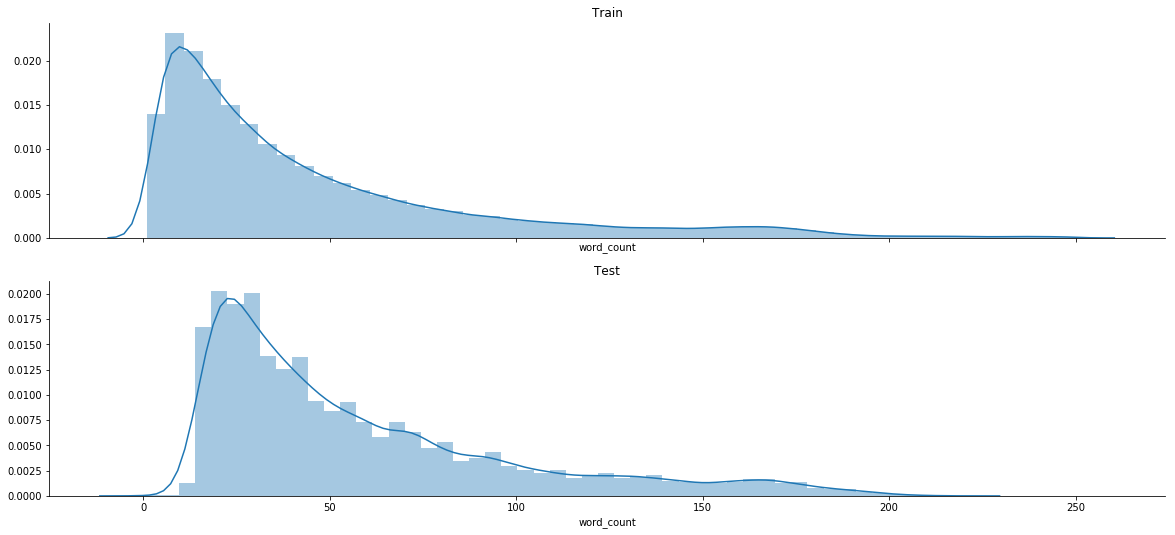

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['word_count'], ax=ax1).set_title("Train")
sns.distplot(test_df['word_count'], ax=ax2).set_title("Test")
sns.despine()
plt.show()

## Token count distribution

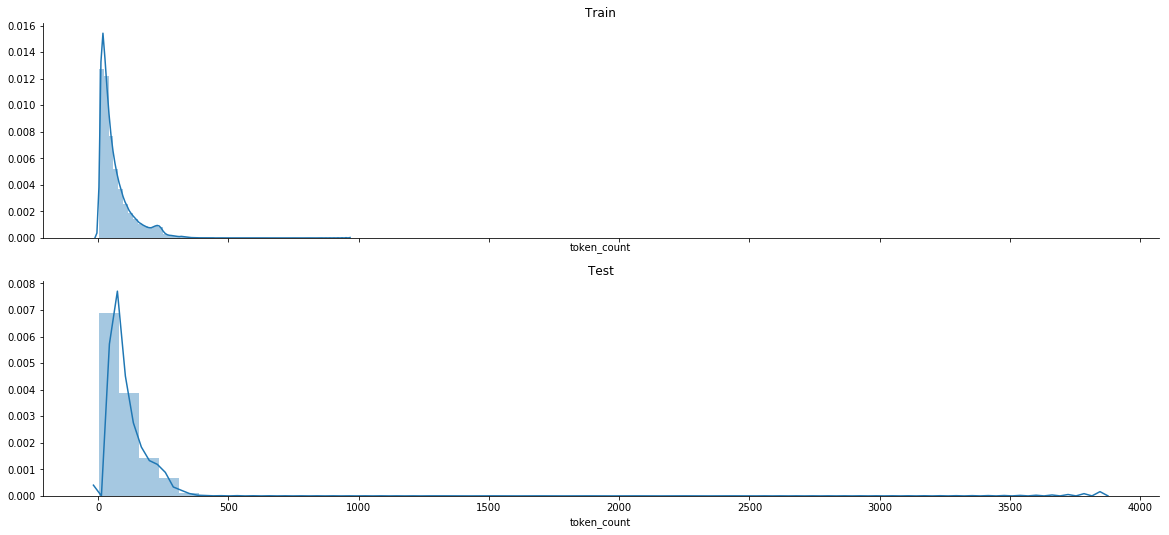

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['token_count'], ax=ax1).set_title("Train")
sns.distplot(test_df['token_count'], ax=ax2).set_title("Test")
sns.despine()
plt.show()